# Compute Validation error

compute Error per scenario and for all replicates together and over time steps for Validation set

The mean error should be:


$$MSE = \frac{1}{n_{time}}\left(\sum_{t} \frac{1}{n_{scen}}\sum_{i}\left(\left(\frac{1}{100}\sum_{j}^{100} \hat{\Theta}_i^j\right) - \Theta_i\right)^2\right)$$

- $j$: replicates
- $i$: scenarios
- $t$: time steps

# import

In [1]:
import sys
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Conv2D, Conv1D
from tensorflow.keras.layers import MaxPooling2D, AveragePooling1D
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
%matplotlib inline
import scipy.stats as ss

sys.path.append("demography")
import utils

# Definitions

In [2]:
batch_size = 200
epochs = 10
nindiv = 50
numParams = 21
NUM_GPU = 1

In [3]:
def resort_min_diff(amat):
    # assumes your snp matrix is indv. on rows, snps on cols
    mb = NearestNeighbors(len(amat), metric='manhattan', n_jobs=1).fit(amat)
    v = mb.kneighbors(amat)
    smallest = np.argmin(v[0].sum(axis=1))
    return amat[v[1][smallest]]


In [4]:
class DataGenerator(keras.utils.Sequence):

    def __init__(self, indices, scen_params_preprocessed, batchSize,
                 SNP_maxx, sort_rows, encodingg, max_distance):
        self.indices = indices
        self.scenario_params_preprocessed = scen_params_preprocessed
        self.batch_size = batchSize
        self.SNP_max = SNP_maxx
        self.sortRows = sort_rows # True/False
        self.encoding = encodingg # "255/1"
        self.maxDistance = max_distance # max distance btw snps

    def __len__(self): # number of batches
        return int(np.ceil(len(self.indices) / float(self.batch_size)))

    def __getitem__(self, idx): # should return entire batch
        batch_snp = []
        batch_pos = []
        batch_demo = []
        batch_scenario_idx = []
        for index in range(idx, idx+batch_size):
            scenario_idx, npz_path = self.indices[index]
            scenario_data = scenario_params_preprocessed.loc[scenario_idx].copy()

            with np.load(npz_path) as data_npz:
                pos = (((data_npz['POS'] / self.maxDistance) / 2e6) * 2) - 1 # positions between -1 and 1
                snp = data_npz["SNP"]
            snp = resort_min_diff(snp) # sort matrix
            if self.encoding == "1":
                snp = snp.astype("float")*2 - 1 # between -1,1
            else:
                snp = (snp*255).astype('int8') # 0->0 ; 255 -> -1

            if self.SNP_max == 400: # truncate up to SNP_max

                batch_pos.append(pos[:self.SNP_max])
                new_snp = snp[:, :self.SNP_max]
                batch_snp.append(new_snp.T)

            else: # need to pad up to 17839 (max number of snp in Theophile's simulations)
                # snp_2_keep = np.sort(np.random.choice(snp.shape[1],
                #                                int(snp.shape[1]/10), # take about 10% of the initial snps
                #                                replace=False))
                # subsample as in flagel's code:
                snp_2_keep = np.arange(snp.shape[1])[::10]
                snp = snp[:, snp_2_keep]
                p_tmp = pos.cumsum()[snp_2_keep] # subsample in the absolute distance space
                pos = np.r_[p_tmp[0], np.diff(p_tmp)] # recompute the diff and concat (r_) with first value

                new_pos = np.zeros(SNP_max)
                new_pos[:pos.shape[0]] = pos
                new_snp = np.zeros((snp.shape[0], SNP_max))
                new_snp[:snp.shape[0], :snp.shape[1]] = snp
                batch_pos.append(new_pos)
                batch_snp.append(new_snp.T)

            batch_demo.append(scenario_data.filter(regex="pop.*size").values) # 21 demo parameters
            batch_scenario_idx.append(scenario_idx)
            
        return np.array(batch_scenario_idx), (np.array(batch_snp), np.array(batch_pos)), np.array(batch_demo)


In [5]:
def build_model(inputShape, convFunc, useDropout):
    #inputShape = (SNP_max, nindiv)
    poolFunc = AveragePooling1D
    b1 = Input(shape=inputShape)
    convSize=2 
    poolSize=2 

    conv11 = convFunc(128, kernel_size=convSize, activation='relu')(b1)
    pool11 = poolFunc(pool_size=poolSize)(conv11)
    if useDropout:
        pool11 = Dropout(0.25)(pool11)
    conv12 = convFunc(128, kernel_size=2, activation='relu')(pool11)
    pool12 = poolFunc(pool_size=poolSize)(conv12)
    if useDropout:
        pool12 = Dropout(0.25)(pool12)
    conv13 = convFunc(128, kernel_size=2, activation='relu')(pool12)
    pool13 = poolFunc(pool_size=poolSize)(conv13)
    if useDropout:
        pool13 = Dropout(0.25)(pool13)
    conv14 = convFunc(128, kernel_size=2, activation='relu')(pool13)
    pool14 = poolFunc(pool_size=poolSize)(conv14)
    if useDropout:
        pool14 = Dropout(0.25)(pool14)
    flat11 = Flatten()(pool14)

    b2 = Input(shape=(SNP_max,))
    dense21 = Dense(32, activation='relu')(b2)
    if useDropout:
        dense21 = Dropout(0.25)(dense21)

    merged = concatenate([flat11, dense21])
    denseMerged = Dense(256, activation='relu',
                        kernel_initializer='normal')(merged)
    if useDropout:
        denseMerged = Dropout(0.25)(denseMerged)
    denseOutput = Dense(numParams)(denseMerged)
    model = Model(inputs=[b1, b2], outputs=denseOutput)
    #print(model.summary())
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [6]:
def run_test(test_batch_generator, model, run_id):
    all_df_pred = pd.DataFrame()
    all_df_exp = pd.DataFrame()
    
    for j,i in enumerate(range(0, len(test_batch_generator.indices), batch_size)):
        batch = test_batch_generator[i]
        pred = model.predict(batch[1])#, verbose=True)
        df_pred = pd.DataFrame(pred)
        df_exp = pd.DataFrame(batch[2].astype(float))
        df_pred["scenario_idx"] = batch[0]
        df_exp["scenario_idx"] = batch[0]
        all_df_pred = pd.concat([all_df_pred, df_pred])
        all_df_exp = pd.concat([all_df_exp, df_exp])
        if j % 50 == 0:
            print("batch {} done".format(j))  
            print(np.unique(batch[0], return_counts=True))
    all_df_pred.set_index("scenario_idx").to_csv("all_pred_{}.csv".format(run_id), sep="\t")
    all_df_exp.set_index("scenario_idx").to_csv("all_exp_TEST_{}.csv".format(run_id), sep="\t")
    return all_df_pred, all_df_exp

# Create loader

In [7]:
preprocessed_scenario_params_path="/home/tau/thsanche/run_long/cattle/special_best_SPIDNA2_fc_400snp/cattle_special_SPIDNA2_fc_400snp_preprocessed_param.csv" 

In [8]:
scenario_params_preprocessed = pd.read_csv(preprocessed_scenario_params_path, index_col=0)

In [9]:
num_scenario = len(scenario_params_preprocessed)
simu_data_path = "/home/tau/thsanche/data/"
print("Building indices...")
training_indices = []
validation_indices = []
for scenario in scenario_params_preprocessed.itertuples(): # here they are all test scenarios
    for k in range(scenario.num_replicates):
        
        data = (scenario.Index,
                os.path.join(simu_data_path,
                            utils.generate_filename((scenario.Index, k),
                                                   "cattle",
                                                   20000, # not used
                                                   scenario.num_replicates,
                                                   return_abs_path=True,
                                                   format_scen="",
                                                   format_rep="",
                                                   )
                            )
               )
        if scenario.training_set:
            training_indices.append(data)
        else:
            validation_indices.append(data)
print("... Done")

Building indices...
... Done


In [10]:
len(validation_indices)

50000

In [11]:
len(training_indices)

1796000

## Archi 1 : All SNP, encoding=255, conv1D, dropout

In [13]:
SNP_max, nindiv = 1784, 50
convFunc = Conv1D
useDropout = True

In [14]:
my_validation_batch_generator1 = DataGenerator(training_indices,
                                              scenario_params_preprocessed,
                                              batch_size,
                                              SNP_max,
                                              sort_rows=True,
                                              encodingg="255",
                                              max_distance=1082459) # 1082459 from sort -k4,4gr cattle_data_clean_more400SNP.csv | head


In [15]:
model1 = build_model(inputShape=(SNP_max, nindiv), convFunc=Conv1D, useDropout=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [16]:
model1.load_weights("Model_weigths_SNP1784_conv1d_drop-True_encode-255_shuf")

In [17]:
all_df_pred1, all_df_exp1 = run_test(my_validation_batch_generator1,
                                     model1,
                                     "TRAIN2_SNP1784_conv1d_drop-True_encode-255_shuf")

batch 0 done
(array([0, 2]), array([100, 100]))
batch 50 done
(array([315, 316]), array([100, 100]))
batch 100 done
(array([589, 590]), array([100, 100]))
batch 150 done
(array([839, 842]), array([100, 100]))
batch 200 done
(array([1134, 1135]), array([100, 100]))
batch 250 done
(array([1405, 1406]), array([100, 100]))
batch 300 done
(array([1721, 1722]), array([100, 100]))
batch 350 done
(array([1992, 1995]), array([100, 100]))
batch 400 done
(array([2272, 2274]), array([100, 100]))
batch 450 done
(array([2556, 2557]), array([100, 100]))
batch 500 done
(array([2785, 2786]), array([100, 100]))
batch 550 done
(array([3083, 3085]), array([100, 100]))
batch 600 done
(array([3365, 3366]), array([100, 100]))
batch 650 done
(array([3665, 3666]), array([100, 100]))
batch 700 done
(array([3891, 3892]), array([100, 100]))
batch 750 done
(array([4171, 4172]), array([100, 100]))
batch 800 done
(array([4432, 4433]), array([100, 100]))
batch 850 done
(array([4703, 4704]), array([100, 100]))
batch 9

batch 7050 done
(array([39277, 39278]), array([100, 100]))
batch 7100 done
(array([39548, 39551]), array([100, 100]))
batch 7150 done
(array([39862, 39868]), array([100, 100]))
batch 7200 done
(array([40139, 40140]), array([100, 100]))
batch 7250 done
(array([40430, 40433]), array([100, 100]))
batch 7300 done
(array([40709, 40710]), array([100, 100]))
batch 7350 done
(array([40956, 40959]), array([100, 100]))
batch 7400 done
(array([41259, 41263]), array([100, 100]))
batch 7450 done
(array([41567, 41568]), array([100, 100]))
batch 7500 done
(array([41816, 41819]), array([100, 100]))
batch 7550 done
(array([42053, 42058]), array([100, 100]))
batch 7600 done
(array([42317, 42318]), array([100, 100]))
batch 7650 done
(array([42610, 42611]), array([100, 100]))
batch 7700 done
(array([42862, 42865]), array([100, 100]))
batch 7750 done
(array([43164, 43167]), array([100, 100]))
batch 7800 done
(array([43414, 43424]), array([100, 100]))
batch 7850 done
(array([43691, 43692]), array([100, 100]

In [9]:
all_df_pred1 = pd.read_csv("./all_pred_TRAIN2_SNP1784_conv1d_drop-True_encode-255_shuf.csv", sep="\t")
all_df_exp1 = pd.read_csv("./all_exp_TEST_TRAIN2_SNP1784_conv1d_drop-False_encode-1_shuf.csv", sep="\t")

In [10]:
MS1 = ((all_df_pred1.groupby("scenario_idx").mean() - all_df_exp1.groupby("scenario_idx").mean())**2)

In [11]:
MSE1 = MS1.T.apply(["mean", "std", "sem"]).T

In [12]:
MSE1.to_csv("MSE_TRAIN2_SNP1784_conv1d_drop-True_encode-255_shuf.csv")

In [13]:
MSE1.mean()

mean    0.444107
std     0.551961
sem     0.120448
dtype: float64

## Archi 2: 400 SNP, encoding=255, conv1D, dropout

In [22]:
SNP_max, nindiv = 400, 50
convFunc = Conv1D
useDropout = True
encoding = "255"

In [23]:
my_validation_batch_generator2 = DataGenerator(training_indices,
                                              scenario_params_preprocessed,
                                              batch_size,
                                              400,
                                              sort_rows=True,
                                              encodingg=encoding,
                                              max_distance=1082459) # 1082459 from sort -k4,4gr cattle_data_clean_more400SNP.csv | head


In [24]:
model2 = build_model(inputShape=(SNP_max, nindiv), convFunc=Conv1D, useDropout=True)

In [25]:
model2.load_weights("Model_weigths_SNP400_conv1d_drop-True_encode-255_shuf")

In [26]:
all_df_pred2, all_df_exp2 = run_test(my_validation_batch_generator2,
                                     model2,
                                     "TRAIN2_SNP400_conv1d_drop-True_encode-255_shuf")

batch 0 done
(array([0, 2]), array([100, 100]))
batch 50 done
(array([315, 316]), array([100, 100]))
batch 100 done
(array([589, 590]), array([100, 100]))
batch 150 done
(array([839, 842]), array([100, 100]))
batch 200 done
(array([1134, 1135]), array([100, 100]))
batch 250 done
(array([1405, 1406]), array([100, 100]))
batch 300 done
(array([1721, 1722]), array([100, 100]))
batch 350 done
(array([1992, 1995]), array([100, 100]))
batch 400 done
(array([2272, 2274]), array([100, 100]))
batch 450 done
(array([2556, 2557]), array([100, 100]))
batch 500 done
(array([2785, 2786]), array([100, 100]))
batch 550 done
(array([3083, 3085]), array([100, 100]))
batch 600 done
(array([3365, 3366]), array([100, 100]))
batch 650 done
(array([3665, 3666]), array([100, 100]))
batch 700 done
(array([3891, 3892]), array([100, 100]))
batch 750 done
(array([4171, 4172]), array([100, 100]))
batch 800 done
(array([4432, 4433]), array([100, 100]))
batch 850 done
(array([4703, 4704]), array([100, 100]))
batch 9

batch 7050 done
(array([39277, 39278]), array([100, 100]))
batch 7100 done
(array([39548, 39551]), array([100, 100]))
batch 7150 done
(array([39862, 39868]), array([100, 100]))
batch 7200 done
(array([40139, 40140]), array([100, 100]))
batch 7250 done
(array([40430, 40433]), array([100, 100]))
batch 7300 done
(array([40709, 40710]), array([100, 100]))
batch 7350 done
(array([40956, 40959]), array([100, 100]))
batch 7400 done
(array([41259, 41263]), array([100, 100]))
batch 7450 done
(array([41567, 41568]), array([100, 100]))
batch 7500 done
(array([41816, 41819]), array([100, 100]))
batch 7550 done
(array([42053, 42058]), array([100, 100]))
batch 7600 done
(array([42317, 42318]), array([100, 100]))
batch 7650 done
(array([42610, 42611]), array([100, 100]))
batch 7700 done
(array([42862, 42865]), array([100, 100]))
batch 7750 done
(array([43164, 43167]), array([100, 100]))
batch 7800 done
(array([43414, 43424]), array([100, 100]))
batch 7850 done
(array([43691, 43692]), array([100, 100]

In [14]:
all_df_pred2 = pd.read_csv("./all_pred_TRAIN2_SNP400_conv1d_drop-True_encode-255_shuf.csv", sep="\t")
all_df_exp2 = pd.read_csv("./all_exp_TEST_TRAIN2_SNP400_conv1d_drop-True_encode-255_shuf.csv", sep="\t")

In [15]:
MS2 = ((all_df_pred2.groupby("scenario_idx").mean() - all_df_exp2.groupby("scenario_idx").mean())**2)

In [16]:
MSE2 = MS2.T.apply(["mean", "std", "sem"]).T

In [17]:
MSE2.to_csv("MSE_TRAIN2_SNP400_conv1d_drop-True_encode-255_shuf.csv")

In [18]:
MSE2.mean()

mean    0.550760
std     0.639974
sem     0.139654
dtype: float64

## Archi 3: All SNP, encoding=1, conv1D, No dropout

In [31]:
SNP_max, nindiv = 1784, 50
convFunc = Conv1D
useDropout = False
encoding = "1"

In [32]:
my_validation_batch_generator3 = DataGenerator(training_indices,
                                              scenario_params_preprocessed,
                                              batch_size,
                                              SNP_max,
                                              sort_rows=True,
                                              encodingg=encoding,
                                              max_distance=1082459) # 1082459 from sort -k4,4gr cattle_data_clean_more400SNP.csv | head


In [33]:
model3 = build_model(inputShape=(SNP_max, nindiv), convFunc=Conv1D, useDropout=useDropout)

In [34]:
model3.load_weights("Model_weigths_SNP1784_conv1d_drop-False_encode-1_shuf")

In [35]:
all_df_pred3, all_df_exp3 = run_test(my_validation_batch_generator3,
                                     model3,
                                     "TRAIN2_SNP1784_conv1d_drop-False_encode-1_shuf")

batch 0 done
(array([0, 2]), array([100, 100]))
batch 50 done
(array([315, 316]), array([100, 100]))
batch 100 done
(array([589, 590]), array([100, 100]))
batch 150 done
(array([839, 842]), array([100, 100]))
batch 200 done
(array([1134, 1135]), array([100, 100]))
batch 250 done
(array([1405, 1406]), array([100, 100]))
batch 300 done
(array([1721, 1722]), array([100, 100]))
batch 350 done
(array([1992, 1995]), array([100, 100]))
batch 400 done
(array([2272, 2274]), array([100, 100]))
batch 450 done
(array([2556, 2557]), array([100, 100]))
batch 500 done
(array([2785, 2786]), array([100, 100]))
batch 550 done
(array([3083, 3085]), array([100, 100]))
batch 600 done
(array([3365, 3366]), array([100, 100]))
batch 650 done
(array([3665, 3666]), array([100, 100]))
batch 700 done
(array([3891, 3892]), array([100, 100]))
batch 750 done
(array([4171, 4172]), array([100, 100]))
batch 800 done
(array([4432, 4433]), array([100, 100]))
batch 850 done
(array([4703, 4704]), array([100, 100]))
batch 9

batch 7050 done
(array([39277, 39278]), array([100, 100]))
batch 7100 done
(array([39548, 39551]), array([100, 100]))
batch 7150 done
(array([39862, 39868]), array([100, 100]))
batch 7200 done
(array([40139, 40140]), array([100, 100]))
batch 7250 done
(array([40430, 40433]), array([100, 100]))
batch 7300 done
(array([40709, 40710]), array([100, 100]))
batch 7350 done
(array([40956, 40959]), array([100, 100]))
batch 7400 done
(array([41259, 41263]), array([100, 100]))
batch 7450 done
(array([41567, 41568]), array([100, 100]))
batch 7500 done
(array([41816, 41819]), array([100, 100]))
batch 7550 done
(array([42053, 42058]), array([100, 100]))
batch 7600 done
(array([42317, 42318]), array([100, 100]))
batch 7650 done
(array([42610, 42611]), array([100, 100]))
batch 7700 done
(array([42862, 42865]), array([100, 100]))
batch 7750 done
(array([43164, 43167]), array([100, 100]))
batch 7800 done
(array([43414, 43424]), array([100, 100]))
batch 7850 done
(array([43691, 43692]), array([100, 100]

In [19]:
all_df_pred3 = pd.read_csv("./all_pred_TRAIN2_SNP1784_conv1d_drop-False_encode-1_shuf.csv", sep="\t")
all_df_exp3 = pd.read_csv("./all_exp_TEST_TRAIN2_SNP1784_conv1d_drop-False_encode-1_shuf.csv", sep="\t")

In [20]:
MS3 = ((all_df_pred3.groupby("scenario_idx").mean() - all_df_exp3.groupby("scenario_idx").mean())**2)

In [21]:
MSE3 = MS3.T.apply(["mean", "std", "sem"]).T

In [22]:
MSE3.to_csv("MSE_TRAIN2_SNP1784_conv1d_drop-False_encode-1_shuf.csv")

In [23]:
MSE3.mean()

mean    0.484456
std     0.607836
sem     0.132641
dtype: float64

## Archi 4: 400 SNP, encoding=1, conv1D, No dropout

In [43]:
SNP_max, nindiv = 400, 50
convFunc = Conv1D
useDropout = False
encoding = "1"

In [44]:
my_validation_batch_generator4 = DataGenerator(training_indices,
                                              scenario_params_preprocessed,
                                              batch_size,
                                              400,
                                              sort_rows=True,
                                              encodingg=encoding,
                                              max_distance=1082459) # 1082459 from sort -k4,4gr cattle_data_clean_more400SNP.csv | head


In [45]:
model4 = build_model(inputShape=(SNP_max, nindiv), convFunc=Conv1D, useDropout=useDropout)

In [46]:
model4.load_weights("Model_weigths_SNP400_conv1d_drop-False_encode-1_shuf")

In [47]:
all_df_pred4, all_df_exp4 = run_test(my_validation_batch_generator4,
                                     model4,
                                     "TRAIN2_SNP400_conv1d_drop-False_encode-1_shuf")

batch 0 done
(array([0, 2]), array([100, 100]))
batch 50 done
(array([315, 316]), array([100, 100]))
batch 100 done
(array([589, 590]), array([100, 100]))
batch 150 done
(array([839, 842]), array([100, 100]))
batch 200 done
(array([1134, 1135]), array([100, 100]))
batch 250 done
(array([1405, 1406]), array([100, 100]))
batch 300 done
(array([1721, 1722]), array([100, 100]))
batch 350 done
(array([1992, 1995]), array([100, 100]))
batch 400 done
(array([2272, 2274]), array([100, 100]))
batch 450 done
(array([2556, 2557]), array([100, 100]))
batch 500 done
(array([2785, 2786]), array([100, 100]))
batch 550 done
(array([3083, 3085]), array([100, 100]))
batch 600 done
(array([3365, 3366]), array([100, 100]))
batch 650 done
(array([3665, 3666]), array([100, 100]))
batch 700 done
(array([3891, 3892]), array([100, 100]))
batch 750 done
(array([4171, 4172]), array([100, 100]))
batch 800 done
(array([4432, 4433]), array([100, 100]))
batch 850 done
(array([4703, 4704]), array([100, 100]))
batch 9

batch 7050 done
(array([39277, 39278]), array([100, 100]))
batch 7100 done
(array([39548, 39551]), array([100, 100]))
batch 7150 done
(array([39862, 39868]), array([100, 100]))
batch 7200 done
(array([40139, 40140]), array([100, 100]))
batch 7250 done
(array([40430, 40433]), array([100, 100]))
batch 7300 done
(array([40709, 40710]), array([100, 100]))
batch 7350 done
(array([40956, 40959]), array([100, 100]))
batch 7400 done
(array([41259, 41263]), array([100, 100]))
batch 7450 done
(array([41567, 41568]), array([100, 100]))
batch 7500 done
(array([41816, 41819]), array([100, 100]))
batch 7550 done
(array([42053, 42058]), array([100, 100]))
batch 7600 done
(array([42317, 42318]), array([100, 100]))
batch 7650 done
(array([42610, 42611]), array([100, 100]))
batch 7700 done
(array([42862, 42865]), array([100, 100]))
batch 7750 done
(array([43164, 43167]), array([100, 100]))
batch 7800 done
(array([43414, 43424]), array([100, 100]))
batch 7850 done
(array([43691, 43692]), array([100, 100]

In [24]:
all_df_pred4 = pd.read_csv("./all_pred_TRAIN2_SNP400_conv1d_drop-False_encode-1_shuf.csv", sep="\t")
all_df_exp4 = pd.read_csv("./all_exp_TEST_TRAIN2_SNP400_conv1d_drop-False_encode-1_shuf.csv", sep="\t")

In [25]:
MS4 = ((all_df_pred4.groupby("scenario_idx").mean() - all_df_exp4.groupby("scenario_idx").mean())**2)

In [26]:
MSE4 = MS4.T.apply(["mean", "std", "sem"]).T

In [27]:
MSE4.to_csv("MSE_TRAIN2_SNP400_conv1d_drop-False_encode-1_shuf.csv")

In [28]:
MSE4.mean()

mean    0.619012
std     0.709667
sem     0.154862
dtype: float64

# Summary

In [133]:
res = pd.concat([MSE1.mean().to_frame(name="TRAIN_SNP1784_conv1d_drop-True_encode-255_shuf"),
                 MSE2.mean().to_frame(name="TRAIN_SNP400_conv1d_drop-True_encode-255_shuf"),
                 MSE3.mean().to_frame(name="TRAIN_SNP1784_conv1d_drop-False_encode-1_shuf"),
                 MSE4.mean().to_frame(name="TRAIN_SNP400_conv1d_drop-False_encode-1_shuf"),
                ], axis=1)

In [134]:
res.T

mean       std       sem
TRAIN_SNP1784_conv1d_drop-True_encode-255_shuf  0.444107  0.551961  0.120448
TRAIN_SNP400_conv1d_drop-True_encode-255_shuf   0.550760  0.639974  0.139654
TRAIN_SNP1784_conv1d_drop-False_encode-1_shuf   0.484456  0.607836  0.132641
TRAIN_SNP400_conv1d_drop-False_encode-1_shuf    0.619012  0.709667  0.154862

Text(0, 0.5, 'MSE')

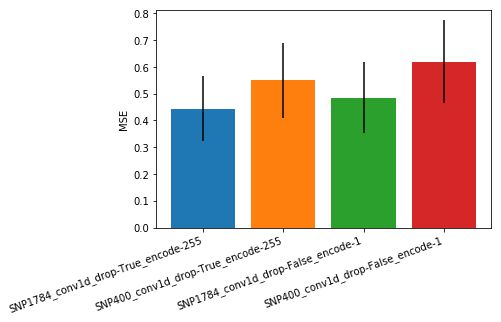

In [78]:
for i,j in enumerate(res.T.itertuples()):
    plt.bar(i, j.mean, yerr=j.sem)
plt.xticks(range(4), [k[5:-5] for k in res.columns], rotation=20, ha="right")
plt.ylabel("MSE")

# Anciens calcules

$$MSE = \frac{1}{n_{time}}\left(\sum_{t} \frac{1}{n_{scen}}\sum_{i}\left(\frac{1}{100}\sum_{j}^{100} \left(\hat{\Theta}_i^j - \Theta_i\right)^2\right)\right)$$

- $j$: replicates
- $i$: scenarios
- $t$: time steps

In [30]:
all_df_pred1.set_index("scenario_idx", inplace=True)
all_df_exp1.set_index("scenario_idx", inplace=True)
all_df_pred2.set_index("scenario_idx", inplace=True)
all_df_exp2.set_index("scenario_idx", inplace=True)
all_df_pred3.set_index("scenario_idx", inplace=True)
all_df_exp3.set_index("scenario_idx", inplace=True)
all_df_pred4.set_index("scenario_idx", inplace=True)
all_df_exp4.set_index("scenario_idx", inplace=True)

In [49]:
MSo1 = ((all_df_pred1 - all_df_exp1)**2).groupby(level=0).mean()

MSoE1 = MSo1.T.apply(["mean", "std", "sem"]).T

MSoE1.mean()

mean    0.530675
std     0.569140
sem     0.124197
dtype: float64

In [50]:
MSo2 = ((all_df_pred2 - all_df_exp2)**2).groupby(level=0).mean()

MSoE2 = MSo2.T.apply(["mean", "std", "sem"]).T

MSoE2.mean()

mean    0.678618
std     0.653016
sem     0.142500
dtype: float64

In [51]:
MSo3 = ((all_df_pred3 - all_df_exp3)**2).groupby(level=0).mean()

MSoE3 = MSo3.T.apply(["mean", "std", "sem"]).T

MSoE3.mean()

mean    0.738396
std     0.634688
sem     0.138500
dtype: float64

In [52]:
MSo4 = ((all_df_pred4 - all_df_exp4)**2).groupby(level=0).mean()

MSoE4 = MSo4.T.apply(["mean", "std", "sem"]).T

MSoE4.mean()

mean    1.012660
std     0.739307
sem     0.161330
dtype: float64

In [74]:
res2 = pd.concat([MSoE1.mean().to_frame(name="TRAIN_SNP1784_conv1d_drop-True_encode-255_shuf"),
                 MSoE2.mean().to_frame(name="TRAIN_SNP400_conv1d_drop-True_encode-255_shuf"),
                 MSoE3.mean().to_frame(name="TRAIN_SNP1784_conv1d_drop-False_encode-1_shuf"),
                 MSoE4.mean().to_frame(name="TRAIN_SNP400_conv1d_drop-False_encode-1_shuf"),
                ], axis=1)

In [75]:
res2.T

mean       std       sem
TRAIN_SNP1784_conv1d_drop-True_encode-255_shuf  0.530675  0.569140  0.124197
TRAIN_SNP400_conv1d_drop-True_encode-255_shuf   0.678618  0.653016  0.142500
TRAIN_SNP1784_conv1d_drop-False_encode-1_shuf   0.738396  0.634688  0.138500
TRAIN_SNP400_conv1d_drop-False_encode-1_shuf    1.012660  0.739307  0.161330

In [88]:
np.array(b.patches[0].get_facecolor())*np.array([1.1, 1.1, 1.1, 1])

array([0.92313725, 0.16823529, 0.17254902, 1.        ])

Text(0.5, 1.0, 'Train error')

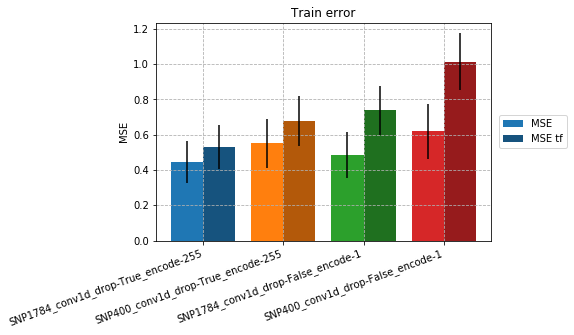

In [130]:
for i,(j,j2) in enumerate(zip(res.T.itertuples(), res2.T.itertuples())):
    b=plt.bar(i-0.2, j.mean, yerr=j.sem, width=0.4, label="MSE")
    plt.bar(i+0.2, j2.mean, yerr=j2.sem, width=0.4,
            color=np.array(b.patches[0].get_facecolor())*np.array([0.7, 0.7, 0.7, 1]),
            #hatch="///",
           label="MSE tf")
plt.xticks(range(4), [k[5:-5] for k in res.columns], rotation=20, ha="right")
plt.ylabel("MSE")
#plt.axhline(1, color="k", linestyle="--", zorder=-100)
#plt.axhline(0.5, color="k", linestyle="--", zorder=-100)
ax = plt.gca()
ax.grid(True, linestyle="--")
ax.legend(ax.patches[:2], ["MSE", "MSE tf"], loc=6, bbox_to_anchor=(1.01, 0.5))
plt.title("Train error")

In [135]:
pd.concat([res.loc["mean"], res2.loc["mean"]], keys=["mse", "tf"]).unstack()

TRAIN_SNP1784_conv1d_drop-True_encode-255_shuf  \
mse                                        0.444107   
tf                                         0.530675   

     TRAIN_SNP400_conv1d_drop-True_encode-255_shuf  \
mse                                       0.550760   
tf                                        0.678618   

     TRAIN_SNP1784_conv1d_drop-False_encode-1_shuf  \
mse                                       0.484456   
tf                                        0.738396   

     TRAIN_SNP400_conv1d_drop-False_encode-1_shuf  
mse                                      0.619012  
tf                                       1.012660